# TGIRT cfRNA-seq comparisons under different salt conc (450mM vs 200mM) #

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
import random
import re
from tgirt_map.table_tool import change_gene_type
from sequencing_tools.fastq_tools import reverse_complement
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sequencing_tools.viz_tools import color_encoder, okabeito_palette, simpsons_palette
from plotting_utils import label_ce, label_sample
from diffexp import py_deseq
from scipy.stats import poisson
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from functools import partial
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)
random.seed(2)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/robject.py:6: UserWarning: Warning message:

  rpy2.rinterface.initr()
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/robject.py:6: UserWarning: package 'methods' was built under R version 3.4.3 

  rpy2.rinterface.initr()
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/robject.py:6: UserWarning: During startup - 
  rpy2.rinterface.initr()
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages

In [65]:
def label_sample(x):
    if 'HS' in x:
        return 'High salt (450mM)'
    elif 'Frag' in x:
        return 'Fragmented'
    elif re.search('[-_]sim',x):
        return 'WGS-sim'
    elif re.search('N[aA]|[Aa]lk', x):
        #return 'Alkaline hydrolysis'
        return 'NaOH'
    elif re.search('L[12]',x):
        return 'PolyA-selected'
    elif re.search('[eE]xo|ED|DE', x):
        return 'DNase I + Exo I'
    elif re.search('[aA]ll|[Uu]nt', x):
        return 'Untreated'
    elif re.search('[Qq][cC][Ff][0-9]+|[uU]nf', x):
        return 'Low salt (200mM)'

# Library complexity #

We know that under low salt condition, the template-switching activity is higher in TGIRT, so we are subsampling the datasets, and see how many genes can be detected under different library size

In [66]:
def sub_saturation(count_df, cutoff=10):
    cum_df = []
    count_df = count_df.query('seq_count > %i' %cutoff)
    for f in np.linspace(0.0001, 1, 1000):
        for (prep, samplename), sample_df in count_df\
                .groupby(['prep','samplename']):
            depth = sample_df.seq_count.sum()
            miRNA_df = sample_df\
                .reset_index()\
                .assign(seq_count = lambda d: d.seq_count * f )
            new_depth = miRNA_df.seq_count.sum()
            miRNA_count = miRNA_df.query('seq_count > %i' %cutoff)\
                .shape[0]
            cum_df.append((prep, samplename, miRNA_count, depth, new_depth, cutoff))
    return pd.DataFrame(cum_df, 
                        columns=['prep','samplename','RNA_count', 
                              'total_depth','sub_depth', 'cutoff'])

In [67]:
count_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/all_counts.tsv'
count_df = pd.read_table(count_table) \
    .query('strand == "sense" & dedup == "all"')\
    .pipe(lambda d: d[d.samplename.str.contains('Q[cC][fF][0-9]+|HS')]) \
    .assign(prep = lambda d: np.where(d.samplename.str.contains('HS'),'High salt','Low salt'))\
    .rename(columns = {'read_count':'seq_count'}) \
    .query('gene_type!="Repeats"') \
    .groupby(['samplename','gene_type','gene_id', 'prep'], as_index=False)\
    .agg({'seq_count':'sum'})
count_df.head()

,samplename,gene_type,gene_id,prep,seq_count
0,QCF1_R1_001,3prime_overlapping_ncRNA,ENSG00000240143.1_5,Low salt,1
1,QCF1_R1_001,3prime_overlapping_ncRNA,ENSG00000259976.3_5,Low salt,2
2,QCF1_R1_001,3prime_overlapping_ncRNA,ENSG00000260108.1_5,Low salt,1
3,QCF1_R1_001,3prime_overlapping_ncRNA,ENSG00000260482.3_5,Low salt,2
4,QCF1_R1_001,IG_C_gene,ENSG00000211677.2_2,Low salt,1


In [68]:
cum_df = []
for cutoff in [10,50,100]:
    cum_df += [sub_saturation(count_df, cutoff)]
cum_df = pd.concat(cum_df)
cum_df.head()

,prep,samplename,RNA_count,total_depth,sub_depth,cutoff
0,High salt,Qcf_HS1_R1_001,0,404878,40.4878,10
1,High salt,Qcf_HS2_R1_001,15,6811797,681.1797,10
2,High salt,Qcf_HS3_R1_001,17,9342334,934.2334,10
3,Low salt,QCF1_R1_001,33,11406087,1140.6087,10
4,Low salt,QCF2_R1_001,42,15542394,1554.2394,10


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


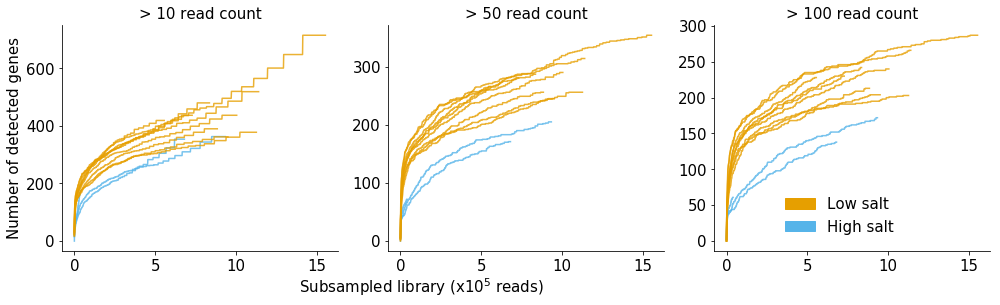

In [132]:
ce = color_encoder()
ce.fit(cum_df.prep.unique())

fig = plt.figure(figsize=(14,4))
for i, (cutoff, cutoff_df) in enumerate(cum_df.groupby('cutoff')):
    ax = fig.add_subplot(1,3,i+1)
    for (prep, samplename), sample_df in cutoff_df\
            .assign(sub_depth = lambda d: d.sub_depth/1e6)\
            .groupby(['prep','samplename']):
        sample_df.plot('sub_depth','RNA_count', 
                   color = ce.encoder[prep], 
                   label = prep, alpha=0.8,
                   ax = ax)
    ax.legend().set_visible(False)
    ax.set_title('> %i read count' %cutoff, size = 15)
    if i ==0:
        ax.set_ylabel('Number of detected genes')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
#    ax.set_xlim(0,10)
sns.despine()
fig.text(0.3,-0.03,'Subsampled library (x$10^5$ reads)',fontsize=15)
ce.show_legend(ax, fontsize=15, frameon=False, bbox_to_anchor=(0.7,0.3))
fig.tight_layout()
fig.savefig('/stor/home/cdw2854/salt_saturation.pdf', bbox_inches='tight')

# Are the gene be detected the same?#

(0.0, 1.0, 0.0, 1.0)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


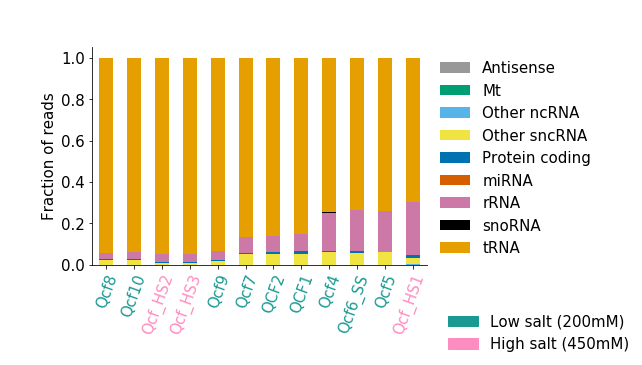

In [71]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['#999999', '#009E73', '#56B4E9', '#F0E442', '#0072B2',
       '#D55E00', '#CC79A7', 'black', '#E69F00']
plot_df = count_df\
    .query('gene_type!="No features"')\
    .assign(gene_type = lambda d: d.gene_type.map(change_gene_type))  \
    .groupby(['samplename','gene_type'], as_index=False)\
    .agg({'seq_count':'sum'})\
    .assign(seq_ratio = lambda d: d.groupby('samplename')['seq_count'].transform(lambda x: x/x.sum()))\
    .assign(samplename = lambda d: d.samplename.str.replace('_R1_001',''))\
    .pipe(pd.pivot_table, index='samplename', columns='gene_type', values = 'seq_ratio') \
    .sort_values('rRNA')
plot_df.plot.bar(stacked=True, color=colors, ax = ax)
sns.despine()
ax.legend(title='', bbox_to_anchor = (1,1),frameon=False, fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('Fraction of reads')
_ = ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=70, rotation_mode='anchor', ha='right')

salt_encoder = color_encoder()
salt_encoder.fit(plot_df.index.map(label_sample), 
                 simpsons_palette()[-2:])


for xt in ax.get_xticklabels():
    prep = label_sample(xt.get_text())
    xt.set_color(salt_encoder.encoder[prep])
ax = fig.add_axes([0,0,1,1])
salt_encoder.show_legend(ax, bbox_to_anchor = (1.4,0),
                        fontsize=15, frameon=False)
ax.axis('off')

# Are there overdispersions in these two preps?#

In [72]:
sample_regex = 'Q[cC][fF][0-9]+|HS|[Aa]ll|N[aA]'
#sample_regex = 'HS'
count_small_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/combined_gene_count.tsv'
count_df = pd.read_table(count_small_table)  
gene_info = count_df.filter(regex='id|name|type')
count_df = count_df \
    .assign(id = lambda d: d.id.str.replace('[0-9]-[0-9]+$',''))\
    .assign(id = lambda d: np.where(d.type=="tRNA",
                                        d.id.str.replace('[0-9]+$',''),
                                        d.id)) \
    .filter(regex = sample_regex + '|id') \
    .groupby('id',as_index=False)\
    .sum()
count_df.head()

,id,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf4_R1_001,Qcf5_R1_001,Qcf6_SS_R1_001,Qcf7_R1_001,Qcf8_R1_001,Qcf9_R1_001,Qcf_All1_R1_001,Qcf_All2_R1_001,Qcf_All3_R1_001,Qcf_HS1_R1_001,Qcf_HS2_R1_001,Qcf_HS3_R1_001,Qcf_NA2_R1_001,Qcf_NA3_R1_001,Qcf_NA4_R1_001,Qcf_Na1_R1_001
0,18S_rRNA,87760.0,135395.5,36359.5,121554.0,79213.5,114917.5,65615.5,30990.5,36169.0,21455.0,55465.5,72087.0,12571.0,28811.0,39625.0,1023.5,1392.0,1275.0,1013.5
1,28S_rRNA,192404.0,272497.5,76302.0,305133.0,199976.5,288669.5,144785.0,62076.5,74673.5,38656.0,130219.5,165838.5,22432.0,59323.0,84889.0,1983.5,3062.0,2672.5,2174.5
2,5.8S_rRNA,83417.0,76761.0,48814.5,254594.5,192064.0,204835.0,108507.5,28831.0,53112.0,15703.0,138239.0,196027.0,15559.0,35226.5,55166.5,121.5,398.0,361.5,159.5
3,5S_rRNA,112836.0,123751.0,36413.5,103664.5,72364.0,99813.0,68344.0,28726.5,22691.5,11363.5,156000.0,249740.5,939.5,4702.0,7247.5,57.5,225.5,189.0,85.0
4,ENSG00000000003.14_2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,25.0,24.0,0.0,0.0,0.0,8.0,29.0,36.0,11.0


In [73]:
count_matrix = count_df.drop(['id'], axis=1)\
    .astype(int)\
    .assign(id = count_df.id)
sample_matrix = pd.DataFrame({'sample': count_matrix.drop('id',axis=1).columns})\
    .assign(treatment = lambda d: d['sample'].map(label_sample))\
    .set_index('sample')
count_matrix.head()

,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf4_R1_001,Qcf5_R1_001,Qcf6_SS_R1_001,Qcf7_R1_001,Qcf8_R1_001,Qcf9_R1_001,Qcf_All1_R1_001,Qcf_All2_R1_001,Qcf_All3_R1_001,Qcf_HS1_R1_001,Qcf_HS2_R1_001,Qcf_HS3_R1_001,Qcf_NA2_R1_001,Qcf_NA3_R1_001,Qcf_NA4_R1_001,Qcf_Na1_R1_001,id
0,87760,135395,36359,121554,79213,114917,65615,30990,36169,21455,55465,72087,12571,28811,39625,1023,1392,1275,1013,18S_rRNA
1,192404,272497,76302,305133,199976,288669,144785,62076,74673,38656,130219,165838,22432,59323,84889,1983,3062,2672,2174,28S_rRNA
2,83417,76761,48814,254594,192064,204835,108507,28831,53112,15703,138239,196027,15559,35226,55166,121,398,361,159,5.8S_rRNA
3,112836,123751,36413,103664,72364,99813,68344,28726,22691,11363,156000,249740,939,4702,7247,57,225,189,85,5S_rRNA
4,0,0,0,0,1,0,0,0,0,7,25,24,0,0,0,8,29,36,11,ENSG00000000003.14_2


In [74]:
deseq2 = py_deseq.py_DESeq2(count_matrix=count_matrix,
                  design_matrix = sample_matrix,
                  design_formula = "~treatment",
                  gene_column = 'id')
deseq2.run_deseq()
deseq2.get_deseq_result()
norm_df = deseq2.normalized_count()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating size factors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserWarning: estimating dispersions

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/rpy2/robjects/functions.py:106: UserW

In [75]:
def extract_cv(norm_df, subsample_regex):
    cv_df = norm_df\
        .reset_index(drop=True)\
        .assign(average = lambda d: d.filter(regex=subsample_regex).mean(axis=1))\
        .assign(var = lambda d: d.filter(regex=subsample_regex).var(axis=1))\
        .assign(cv = lambda d: np.sqrt(d['var'])/d['average']) \
        .assign(log_average = lambda d: d.average.transform(np.log10))\
        .query('average > 0') \
        .merge(gene_info, on ='id')
    return cv_df

def measure_dispersion(mu, var, phi):
    predict_var = mu * (1 + phi * mu)
    return mean_squared_error(np.log(var), np.log(predict_var))

def find_overdisperse(sub_cv_df):
    optim_func = partial(measure_dispersion, sub_cv_df['average'], sub_cv_df['var'])
    min_res = minimize(optim_func, x0 = [0])
    print(min_res.x)
    return min_res

def genewise_dispersion(mu, var):
    phi = (var - mu) / mu**2
    return phi

In [76]:
labels = ['High salt','Low salt', 'Combined']
regexes = ['HS','Q[cC][fF][0-9]+','Q[cC][fF][0-9]+|HS']
cv_dfs = []
overdispersion_paramter = []
for subsample_regex in regexes:
    cv_df  = extract_cv(norm_df, subsample_regex=subsample_regex)
    min_res = find_overdisperse(cv_df)
    cv_dfs += [cv_df]
    overdispersion_paramter += [min_res.x]

[0.23476044]
[0.10366422]
[0.16616668]


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


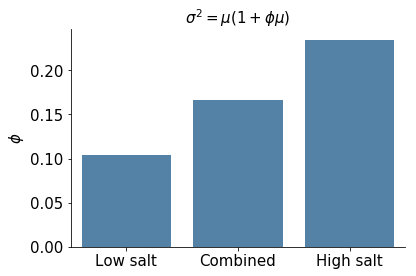

In [77]:
ax = plt.subplot()
dis_df = pd.DataFrame({'sig':list(map(lambda x: x[0], overdispersion_paramter)),
                    'lab':labels}) \
    .sort_values('sig')
sns.barplot(data = dis_df,x='lab', y='sig', color = 'steelblue', ax = ax)
ax.set_title('$\sigma^2 = \mu (1+\phi \mu)$', size=15)
ax.set_ylabel('$\phi$')
ax.set_xlabel('')
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


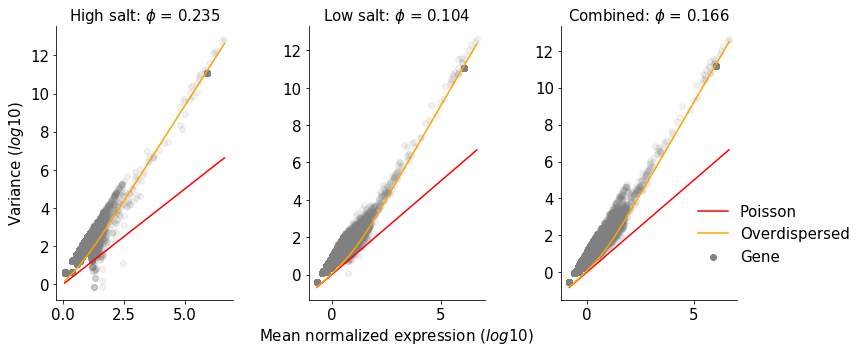

In [79]:
fig = plt.figure(figsize = (12,5))
for i, (cv_df, op, lab) in enumerate(zip(cv_dfs, overdispersion_paramter, labels)):
    ax = fig.add_subplot(1,3,i+1)
    cv_df = cv_df.sort_values('average')
    mu = cv_df['average']
    var = cv_df['var']
    cv = np.sqrt(cv_df['var']) / mu
    
    ax.scatter(np.log10(mu),
               np.log10(var), 
               color = 'gray',
                alpha=0.1, label = 'Gene')
    
    
    #poisson
    sigma = np.sqrt(mu)
    cv = sigma/mu 
    ax.plot(np.log10(mu),np.log10(sigma**2), label='Poisson', color='red')
    
    # over disperse
    var = mu * (1 + op * mu)
    sigma = np.sqrt(var)
    cv = sigma/mu
    ax.plot(np.log10(mu),np.log10(var), label='Overdispersed', color='orange')
    
    ax.set_title('%s: $\phi$ = %.3f' %(lab, op),size=15)
    if i == 0:
        ax.set_ylabel('Variance ($log10$)')
    
    if i ==1:
        ax.set_xlabel('Mean normalized expression ($log10$)')
sns.despine()
lgd = ax.legend(bbox_to_anchor = (0.7,0.4), fontsize=15, frameon=False)
for lh in lgd.legendHandles: 
    lh.set_alpha(1)
fig.tight_layout()

# Genewise dispersion #

In [80]:
cv_dfs=[]
overdispersion_paramter = []
for subsample_regex, lab in zip(regexes, labels):
    cv_df  = extract_cv(norm_df, subsample_regex=subsample_regex) \
        .assign(phi = lambda d: list(map(genewise_dispersion, d['average'], d['var'])))
    cv_dfs += [cv_df.assign(label = lab)]
cv_df = pd.concat(cv_dfs) \
    .assign(log_phi = lambda d: np.log10(d.phi))
cv_df.head()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


,QCF1_R1_001,QCF2_R1_001,Qcf10_R1_001,Qcf4_R1_001,Qcf5_R1_001,Qcf6_SS_R1_001,Qcf7_R1_001,Qcf8_R1_001,Qcf9_R1_001,Qcf_All1_R1_001,...,average,var,cv,log_average,grouped_type,type,name,phi,label,log_phi
0,286156.403673,249860.936035,133432.944730,7.245189e+05,5.993182e+05,6.988228e+05,392123.415767,185693.411419,179971.193266,1647.921922,...,159525.337907,4.928408e+09,0.440072,5.202830,rRNA,rDNA,18S_rRNA,0.193657,High salt,-0.712967
1,627365.960487,502872.007732,280018.717479,1.818736e+06,1.513000e+06,1.755428e+06,865253.200514,371962.058962,371560.975275,2969.101367,...,310809.458492,1.193337e+10,0.351469,5.492494,rRNA,rDNA,28S_rRNA,0.123527,High salt,-0.908237
2,271995.313642,141656.451944,179141.224018,1.517500e+06,1.453138e+06,1.245624e+06,648451.352200,172756.590662,264276.867393,1206.120622,...,204332.353998,7.393871e+09,0.420822,5.310337,rRNA,rDNA,5.8S_rRNA,0.177087,High salt,-0.751814
3,367920.965871,228372.840174,133631.117920,6.178861e+05,5.474993e+05,6.069738e+05,408432.259806,172127.426151,112906.808217,872.772631,...,20001.616127,2.960981e+07,0.272052,4.301065,rRNA,rDNA,5S_rRNA,0.073963,High salt,-1.130988
4,9.782010,3.690844,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,4.975841,2.765099,...,1.206121,4.364183e+00,1.732051,0.081391,Protein coding,protein_coding,SCYL3,2.170896,High salt,0.336639


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'$\\sigma^2 = \\mu (1+\\phi\\mu)$')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


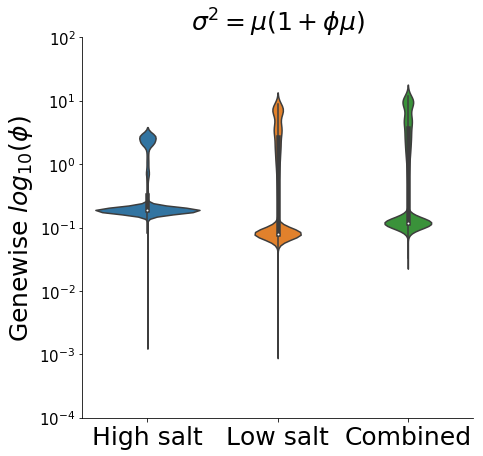

In [81]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot()
sns.violinplot(data = cv_df, 
               
               x = 'label', 
               y = 'log_phi',
              ax = ax)
yrange = np.arange(-4,3)
ax.set_ylim(yrange[0],yrange[-1])
ax.set_yticks(yrange)
ytl = ['$10^{%i}$' %(y) for y in yrange]
ax.set_yticklabels(ytl)
ax.set_ylabel('Genewise $log_{10}(\phi)$', fontsize=25)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=25)
ax.set_xlabel('')
sns.despine()
ax.set_title('$\sigma^2 = \mu (1+\phi\mu)$',size=25)

In [82]:
log_count_df  = norm_df\
    .drop(['id'], axis=1)\
    .transform(lambda x: np.log(x+1))\
    .transpose()

In [83]:
n_components = 10
all_prep_encoder = color_encoder()
pca = PCA(n_components=n_components)
x = pca.fit_transform(log_count_df)
pca_df = pd.DataFrame(x, columns = ['PC%i' %(n + 1) for n in range(n_components)]) \
    .assign(samplename = log_count_df.index) \
    .assign(prep = lambda d: d.samplename.map(label_sample))\
    .assign(color = lambda d: all_prep_encoder.fit_transform(d.prep))
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,samplename,prep,color
0,-37.641093,-37.649395,-36.157906,-8.541374,5.102307,-10.405351,-48.025911,-45.206046,87.950049,-9.797490,QCF1_R1_001,Low salt (200mM),#56B4E9
1,-29.331632,-34.190798,-21.813443,0.026870,2.195198,-11.080941,-31.654026,-19.139899,26.496755,0.226251,QCF2_R1_001,Low salt (200mM),#56B4E9
2,-28.588612,-16.033167,-30.851438,-3.160673,-6.479251,-13.696405,-1.647719,-0.092036,5.775815,-0.022032,Qcf10_R1_001,Low salt (200mM),#56B4E9
3,-88.450961,-45.575034,79.574792,-102.313769,6.318195,-38.059820,35.004603,2.388474,0.516929,-1.667935,Qcf4_R1_001,Low salt (200mM),#56B4E9
4,-104.644395,-13.480671,37.180094,-3.360726,-67.152024,93.022070,-59.070661,1.041313,-30.853335,-0.757106,Qcf5_R1_001,Low salt (200mM),#56B4E9


In [84]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,samplename,prep,color
0,-37.641093,-37.649395,-36.157906,-8.541374,5.102307,-10.405351,-48.025911,-45.206046,87.950049,-9.797490,QCF1_R1_001,Low salt (200mM),#56B4E9
1,-29.331632,-34.190798,-21.813443,0.026870,2.195198,-11.080941,-31.654026,-19.139899,26.496755,0.226251,QCF2_R1_001,Low salt (200mM),#56B4E9
2,-28.588612,-16.033167,-30.851438,-3.160673,-6.479251,-13.696405,-1.647719,-0.092036,5.775815,-0.022032,Qcf10_R1_001,Low salt (200mM),#56B4E9
3,-88.450961,-45.575034,79.574792,-102.313769,6.318195,-38.059820,35.004603,2.388474,0.516929,-1.667935,Qcf4_R1_001,Low salt (200mM),#56B4E9
4,-104.644395,-13.480671,37.180094,-3.360726,-67.152024,93.022070,-59.070661,1.041313,-30.853335,-0.757106,Qcf5_R1_001,Low salt (200mM),#56B4E9
5,-74.094426,-67.875408,64.517074,111.646208,22.232108,-22.246659,23.206239,2.458110,-0.225728,3.468791,Qcf6_SS_R1_001,Low salt (200mM),#56B4E9
6,-76.489034,-29.811517,-55.013357,-15.357630,91.084024,73.798783,40.265338,29.625837,-12.881185,-1.631736,Qcf7_R1_001,Low salt (200mM),#56B4E9
7,-65.222271,8.027671,-53.855355,8.855777,-72.562587,-5.329821,86.803168,-57.642023,-22.196213,3.725655,Qcf8_R1_001,Low salt (200mM),#56B4E9
8,-49.371305,-7.097538,-46.090782,2.897840,-44.385896,-48.804904,-14.634011,110.356473,-3.516169,8.514864,Qcf9_R1_001,Low salt (200mM),#56B4E9
9,93.124251,-5.739497,0.049113,-1.120330,-1.689263,1.985680,1.055204,0.528774,-0.161176,-0.461354,Qcf_All1_R1_001,Untreated,#E69F00


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


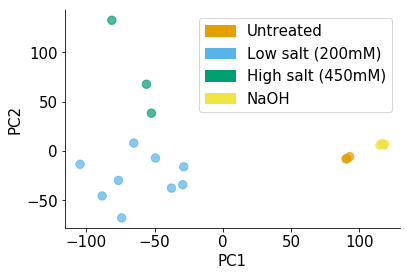

In [85]:
ax = plt.subplot()
pca_df.plot.scatter('PC1', 'PC2', 
                    color = pca_df.color, ax = ax,
                   s=70, alpha=0.7)
all_prep_encoder.show_legend(ax, fontsize=15)
sns.despine()

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


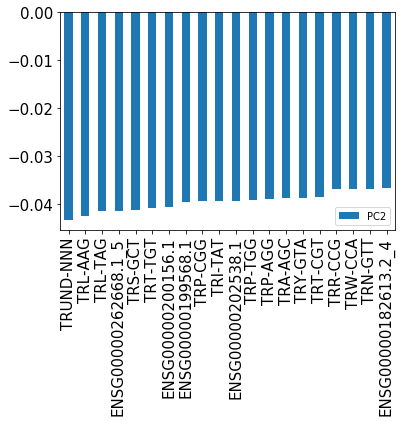

In [86]:
pd.DataFrame(pca.components_, columns = log_count_df.columns) \
    .transpose() \
    .rename(columns = lambda x: 'PC'+str(x+1)) \
    .assign(pc2_abs = lambda d: d.PC2.transform(np.abs))\
    .nlargest(20, 'pc2_abs')\
    .filter(['PC2'])\
    .plot.bar()

# Non-template addition #

In [100]:
non_temp_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/picard_qc/non_template_table.tsv'
non_temp_df = pd.read_table(non_temp_table)\
    .assign(prep = lambda d: d.samplename.map(label_sample))  
non_temp_df.head()

,non_template,non_template_count,samplename,prep
0,.,3449018.0,Qcf_All3_R1_001,Untreated
1,T,237061.0,Qcf_All3_R1_001,Untreated
2,C,47466.0,Qcf_All3_R1_001,Untreated
3,G,8313.0,Qcf_All3_R1_001,Untreated
4,A,6750.0,Qcf_All3_R1_001,Untreated


In [101]:
non_temp_ratio_df = non_temp_df \
    .assign(added = lambda d: np.where(d.non_template == ".", 'Null', '(+)')) \
    .groupby(['samplename','prep','added'], as_index=False)\
    .agg({'non_template_count':'sum'}) \
    .pipe(pd.pivot_table, columns = 'added', values = 'non_template_count', index=['prep','samplename']) \
    .reset_index()\
    .assign(ratio = lambda d: d['(+)']/d['Null']) \
    .pipe(lambda d: d[d.samplename.str.contains('Q[cC][fF][0-9]+|HS')])
non_temp_ratio_df.head()

added,prep,samplename,(+),Null,ratio
5,High salt (450mM),Qcf_HS1_R1_001,735.0,29257.0,0.025122
6,High salt (450mM),Qcf_HS2_R1_001,3202.0,159072.0,0.020129
7,High salt (450mM),Qcf_HS3_R1_001,4997.0,221103.0,0.022600
8,Low salt (200mM),QCF1_R1_001,13054.0,282373.0,0.046230
9,Low salt (200mM),QCF2_R1_001,16062.0,333448.0,0.048169


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


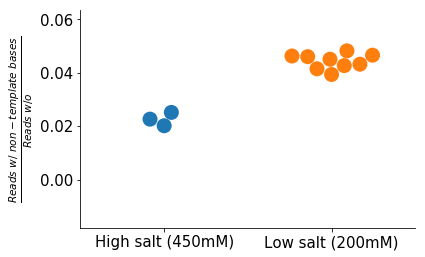

In [129]:
plt.rcParams['text.usetex'] =False
prep_sort = non_temp_ratio_df\
    .groupby('prep',as_index=False)\
    .agg({'ratio':'mean'})\
    .sort_values('ratio')
ax = plt.subplot()
sns.swarmplot(data = non_temp_ratio_df,
              order = prep_sort.prep,
              size=15,
             x = 'prep', y = 'ratio', ax =ax,
            orient = 'v')
#_ = ax.set_xticklabels(ax.get_xticklabels(), 
#                  rotation=70, rotation_mode='anchor',
#                  ha ='right')
ax.set_ylabel(r'$\frac{Reads\ w/\ non-template\ bases}{Reads\ w/o}$')
ax.set_xlabel('')
sns.despine()

In [103]:
non_temp_count = non_temp_df \
    .assign(base_added = lambda d: np.where(d.non_template!=".",
                                           d.non_template.map(lambda x: len(x)),
                                           0)) \
    .groupby(['prep','samplename','base_added'], as_index=False)\
    .agg({'non_template_count':'sum'}) \
    .pipe(lambda d: d.merge(d\
                            .query('base_added==0')\
                            .filter(['samplename','non_template_count'])\
                           .rename(columns={'non_template_count':'nf'}),
                           how ='left'))  \
    .assign(norm_count = lambda d: d.non_template_count/d.nf) \
    .query('base_added != 0') \
    .pipe(lambda d: d[d.samplename.str.contains('Q[cC][fF][0-9]+|HS')])
non_temp_count.head()

,prep,samplename,base_added,non_template_count,nf,norm_count
16,High salt (450mM),Qcf_HS1_R1_001,1,735.0,29257.0,0.025122
18,High salt (450mM),Qcf_HS2_R1_001,1,3201.0,159072.0,0.020123
19,High salt (450mM),Qcf_HS2_R1_001,2,1.0,159072.0,0.000006
21,High salt (450mM),Qcf_HS3_R1_001,1,4996.0,221103.0,0.022596
22,High salt (450mM),Qcf_HS3_R1_001,2,1.0,221103.0,0.000005


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


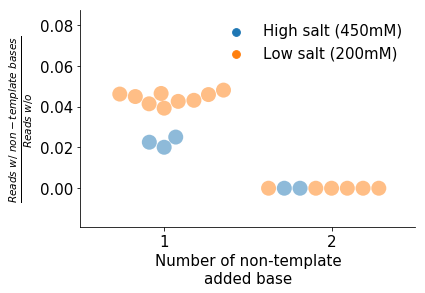

In [130]:
prep_sort = non_temp_count\
    .groupby('prep',as_index=False)\
    .agg({'norm_count':'mean'})\
    .sort_values('norm_count')
ax = plt.subplot()
sns.swarmplot(data = non_temp_count,
              size=15,
              hue = 'prep',
              hue_order = ['High salt (450mM)','Low salt (200mM)'],
              x = 'base_added', y = 'norm_count', ax =ax,
              alpha=0.5, 
             orient = 'v')
#_ = ax.set_xticklabels(ax.get_xticklabels(), 
#                  rotation=70, rotation_mode='anchor',
#                  ha ='right')
ax.set_ylabel(r'$\frac{Reads\ w/\ non-template\ bases}{Reads\ w/o}$')
ax.set_xlabel('Number of non-template\nadded base')
sns.despine()
ax.legend(fontsize=15, title='', frameon=False, loc = 'upper right')

Text(0,0.5,'Fraction of non-template added base')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


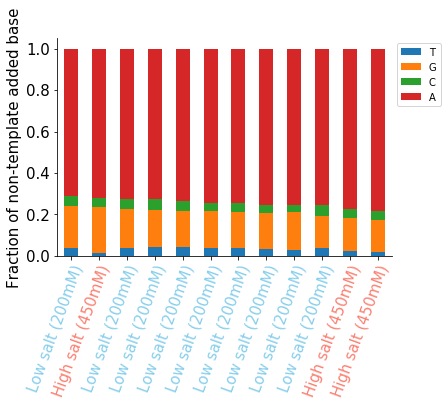

In [114]:
ax = plt.subplot()
non_temp_df\
    .pipe(lambda d: d[d.samplename.str.contains(regexes[-1])])\
    .assign(base_added = lambda d: np.where(d.non_template!=".",
                                           d.non_template.map(lambda x: len(x)),
                                           0)) \
    .pipe(lambda d: d.query('base_added == 0')\
                  .filter(['samplename','non_template_count'])\
                  .rename(columns={'non_template_count':'nf'})\
                  .merge(d)) \
    .query('non_template != "N"')\
    .query('base_added > 0')\
    .assign(norm_count = lambda d: d.groupby(['samplename','base_added'])\
                                            .non_template_count\
                                            .transform(lambda x: x/x.sum())) \
    .query('base_added == 1') \
    .pipe(pd.pivot_table, index = ['prep','samplename'],
             columns = 'non_template', values='norm_count')\
        .reset_index()\
        .drop('samplename', axis=1)\
        .set_index('prep')\
        .sort_values('T')\
        .rename(columns = reverse_complement)\
        .plot.bar(stacked=True, ax = ax)
        
sns.despine()
ax.legend(bbox_to_anchor = (1,1))
ax.set_xticklabels(ax.get_xticklabels(), rotation_mode='anchor', 
                   ha='right', rotation = 70)
for xt in ax.get_xticklabels():
    if 'High' in xt.get_text():
        xt.set_color('salmon')
    else:
        xt.set_color('skyblue')
ax.set_xlabel('')
ax.set_ylabel('Fraction of non-template added base')

In [109]:
map_df = pd.read_csv('/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map_new_penalty/map_stat.csv') \
    .assign(hisat_map = lambda d: d['HISAT mapped pairs']/d['non tRNA/rRNA/YRNA pairs']) \
    .assign(bowtie_map = lambda d: d['BOWTIE2 mapped pairs']/d['non tRNA/rRNA/YRNA pairs']) \
    .assign(total_map = lambda d: d['HISAT mapped pairs'] + d['BOWTIE2 mapped pairs'] + d['tRNA/rRNA/YRNA pairs']) \
    .assign(mapping_rate = lambda d: d.total_map *100/ d['Trimmed pairs']) \
    .assign(prep = lambda d: d['Sample name'].map(label_sample)) \
    .pipe(lambda d: d[d['Sample name'].str.contains('Q[cC][fF][0-9+]|HS')]) 
map_df.head()

,Sample name,Raw pairs,Trimmed pairs,tRNA/rRNA/YRNA pairs,non tRNA/rRNA/YRNA pairs,HISAT mapped pairs,HISAT uniquely mapped,BOWTIE2 mapped pairs,BOWTIE2 uniquely mapped,hisat_map,bowtie_map,total_map,mapping_rate,prep
0,Qcf10,14321566,12854786,11063610.0,1791176,534125.0,402077,132630.0,69945,0.298198,0.074046,11730365.0,91.252900,Low salt (200mM)
1,Qcf4,12209553,10301656,7999866.0,2301790,623710.0,406413,163406.0,78963,0.270967,0.070991,8786982.0,85.296791,Low salt (200mM)
2,Qcf5,9835292,6963814,5324524.0,1639290,413980.0,278864,123033.0,58718,0.252536,0.075053,5861537.0,84.171361,Low salt (200mM)
3,Qcf6_SS,10798548,8974735,7023331.0,1951404,553789.0,404013,136274.0,68751,0.283790,0.069834,7713394.0,85.945646,Low salt (200mM)
4,Qcf7,13188083,11784043,9519478.0,2264565,775678.0,464881,214046.0,103817,0.342528,0.094520,10509202.0,89.181633,Low salt (200mM)


Text(0,0.5,'Mapping rate (%)')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


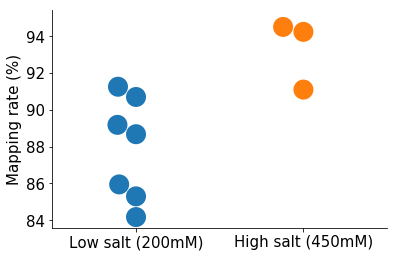

In [110]:
ax = plt.subplot()
sns.swarmplot(data=map_df, 
              x = 'prep', 
              y = 'mapping_rate',
             size = 20,
             ax= ax)
sns.despine()
ax.set_xlabel('')
ax.set_ylabel('Mapping rate (%)')